In [8]:
import os
import numpy as np  
from PIL import Image
import tensorflow as tf 
from keras import backend as K           
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import sklearn.metrics as metrics
from keras.models import load_model
from skimage.transform import resize
from keras.preprocessing import image  
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

## Load Data

In [9]:
folder_benign_train = r'C:\Users\11609\Desktop\sem1\ML\cw\cousework2\archive\train\benign'
folder_malignant_train = r'C:\Users\11609\Desktop\sem1\ML\cw\cousework2\archive\train\malignant'

folder_benign_test = r'C:\Users\11609\Desktop\sem1\ML\cw\cousework2\archive\test\benign'
folder_malignant_test = r'C:\Users\11609\Desktop\sem1\ML\cw\cousework2\archive\test\malignant'

In [10]:
# Load in training pictures 
ims_benign = [Image.open(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array([np.array(im) for im in ims_benign])

ims_malignant = [Image.open(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array([np.array(im) for im in ims_malignant])
# Create labels for training data
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

# Load in testing pictures 
ims_benign_test = [Image.open(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array([np.array(im) for im in ims_benign_test])

ims_malignant_test = [Image.open(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array([np.array(im) for im in ims_malignant_test])
# Create labels for testing data

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

In [11]:
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

## Represented by a bar chart

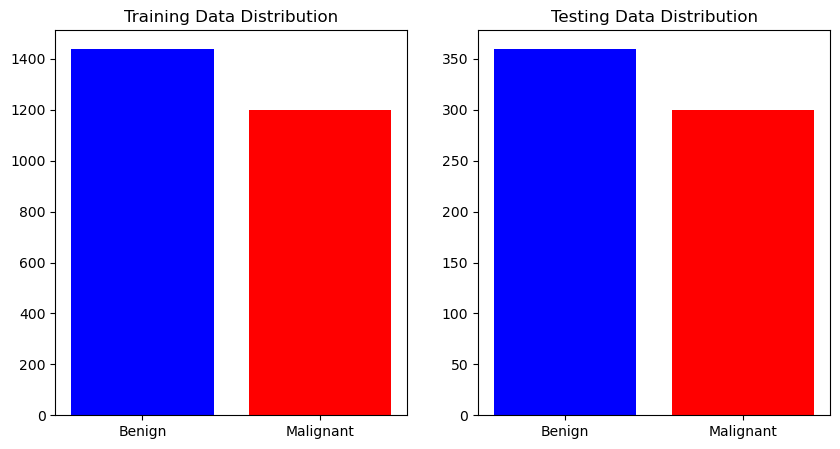

In [12]:
train_benign_count = np.sum(y_train == 0)
train_malignant_count = np.sum(y_train == 1)
test_benign_count = np.sum(y_test == 0)
test_malignant_count = np.sum(y_test == 1)
labels = ['Benign', 'Malignant']
train_counts = [train_benign_count, train_malignant_count]
test_counts = [test_benign_count, test_malignant_count]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.bar(labels, train_counts, color=['blue', 'red'])
ax1.set_title('Training Data Distribution')
ax2.bar(labels, test_counts, color=['blue', 'red'])
ax2.set_title('Testing Data Distribution')
plt.show()

## Check length of Train and Test

In [13]:
len(X_train)

2637

In [14]:
len(X_test)

660

In [15]:
# random data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

## Preprocessing Image with Grayscale and Binarization

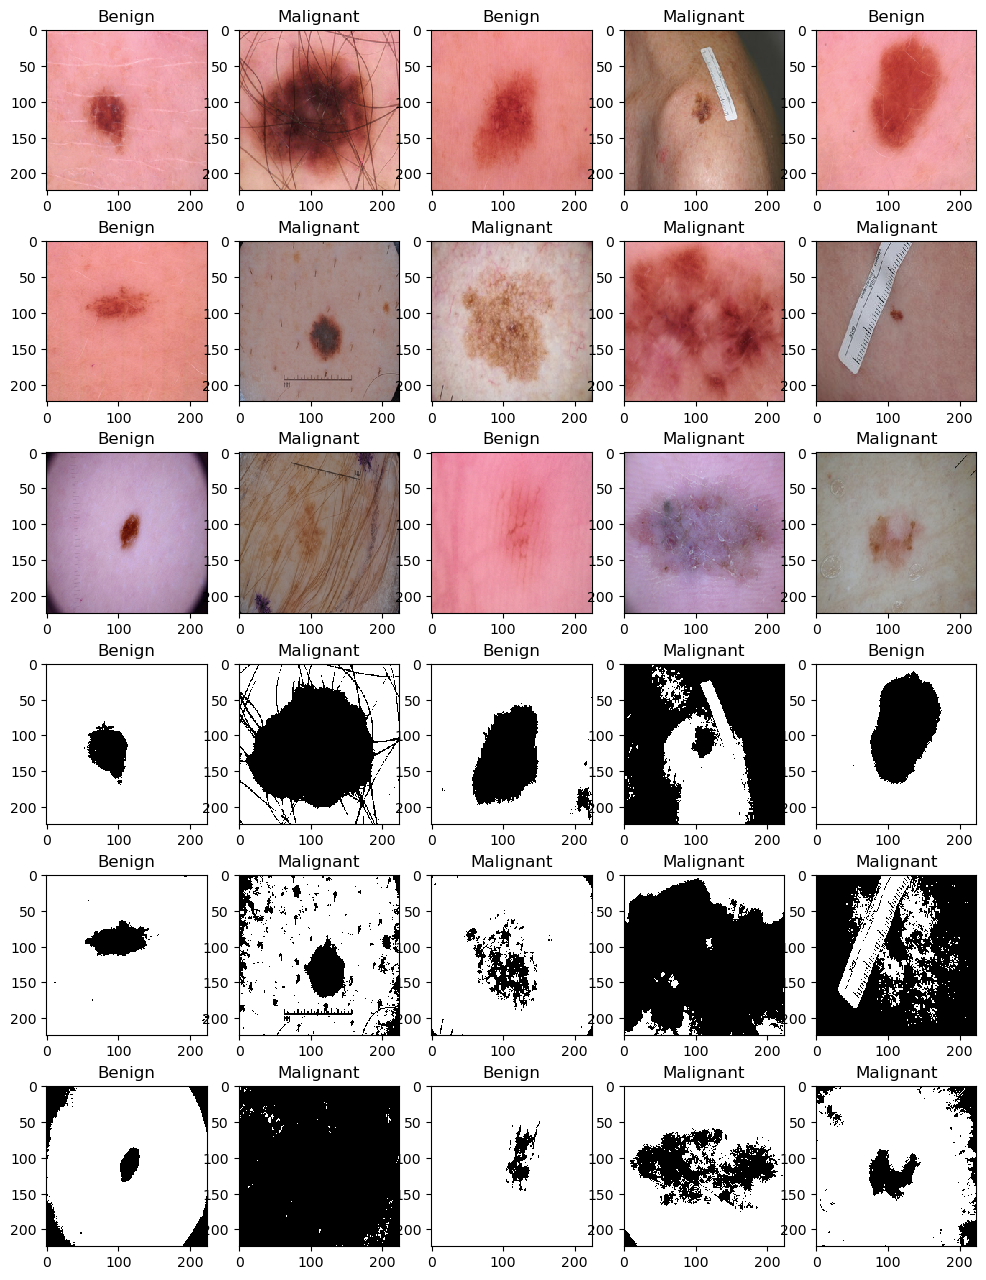

In [16]:
w = 40
h = 30
fig = plt.figure(figsize=(12, 16))  
columns = 5
rows = 6  

for i in range(1, columns * rows + 1):
    ax = fig.add_subplot(rows, columns, i)
    
    if i <= columns * (rows // 2):
        if y_train[i] == 0:
            ax.title.set_text('Benign')
        else:
            ax.title.set_text('Malignant')
        plt.imshow(X_train[i], interpolation='nearest')
    else:
        if y_train[i - columns * (rows // 2)] == 0:
            ax.title.set_text('Benign')
        else:
            ax.title.set_text('Malignant')
        gray_img = cv2.cvtColor(X_train[i - columns * (rows // 2)], cv2.COLOR_BGR2GRAY) 
        _, binary_img = cv2.threshold(gray_img, 128, 255, cv2.THRESH_BINARY)
        plt.imshow(binary_img, cmap='gray', interpolation='nearest')

plt.show()

## Process all data

In [17]:
def preprocess_image(img):
    # Grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Binarization
    _, binary_img = cv2.threshold(gray_img, 128, 255, cv2.THRESH_BINARY)
    
    return binary_img
# train set
X_train_processed = np.array([preprocess_image(img) for img in X_train])

# test set
X_test_processed = np.array([preprocess_image(img) for img in X_test])

In [82]:
print ('The shape of X is: ' + str(X_train_processed.shape))
print ('The shape of y is: ' + str(y_train.shape))

The shape of X is: (2637, 224, 224)
The shape of y is: (2637,)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


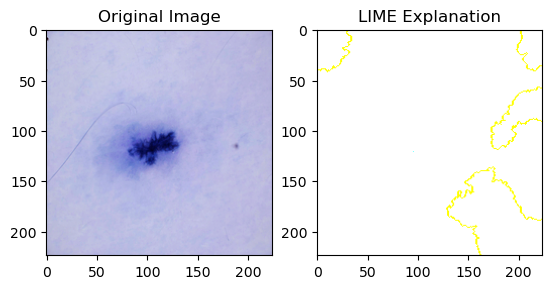

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense

# Load your Keras model
model_path = 'C:\\Users\\11609\\Desktop\\sem1\\ML\\cw\\cousework2\\mymodel.h5'  
model_binary_crossentropy = load_model(model_path)

# Function to preprocess images for interpretation
def preprocess_image_for_interpretation(image_path):
    img = cv2.imread(image_path)
    input_size = (224, 224)  
    img = cv2.resize(img, input_size)
    return img

# Function to preprocess images for prediction
def preprocess_image_for_prediction(img):
    input_size = (224, 224)  
    img = cv2.resize(img, input_size)
    
    # Grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Binarization
    _, binary_img = cv2.threshold(gray_img, 128, 255, cv2.THRESH_BINARY)

    return binary_img

# Function to predict with the model
def predict_fn(images):
    # Assuming images is a 4D array (batch_size, height, width, channels)
    flattened_images = np.array([preprocess_image_for_prediction(img) for img in images])
    flattened_images = flattened_images.reshape((flattened_images.shape[0], -1))
    return model_binary_crossentropy.predict(flattened_images)

# Load your image for interpretation
image_to_interpret_path = r'C:\Users\11609\Desktop\sem1\ML\cw\cousework2\archive\test\benign\1.jpg'
image_to_interpret_rgb = preprocess_image_for_interpretation(image_to_interpret_path)

# Create LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain the prediction for the selected image
explanation = explainer.explain_instance(image_to_interpret_rgb, predict_fn, top_labels=2, hide_color=0, num_samples=1000)

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(image_to_interpret_rgb)
plt.title('Original Image')

# Display the LIME explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title('LIME Explanation')

plt.show()

## structure Sparse Categorical Crossentropy Loss

In [83]:
def custom_sparse_categorical_crossentropy(y_true, y_pred):
    # Scale y_true to the integer range
    scaled_y_true = y_true * (tf.shape(y_pred)[-1] - 1)
    
    # Convert scaled_y_true to integers
    scaled_y_true = tf.cast(scaled_y_true, tf.int32)
    
    # Convert true labels to one-hot encoding
    y_true_one_hot = tf.one_hot(scaled_y_true, depth=tf.shape(y_pred)[-1])
    
    # Convert one-hot encoding back to float
    y_true_one_hot = tf.cast(y_true_one_hot, tf.float32)
    
    # Calculate cross-entropy loss
    cross_entropy = -tf.reduce_sum(y_true_one_hot * tf.math.log(y_pred + 1e-9), axis=-1)
    
    # Average the loss across all samples
    loss = tf.reduce_mean(cross_entropy)
    
    return loss

## Structure neural network

In [ ]:
def custom_loss(y_true, y_pred):
    # Custom implementation of your loss function
    # mean squared error with a penalty term
    mse_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    
    # Add your penalty term or any additional calculations here
    penalty = 0.01
    total_loss = mse_loss + penalty
    
    return total_loss

# Define custom accuracy metric
def custom_accuracy(y_true, y_pred):
    # Custom implementation of your accuracy metric
    # Replace this with your own accuracy calculation
    return tf.keras.metrics.categorical_accuracy(y_true, y_pred)

# Reshape the data
X_train_flatten = X_train_processed.reshape((X_train_processed.shape[0], -1))
X_test_flatten = X_test_processed.reshape((X_test_processed.shape[0], -1))

# Build and train the ANN for feature extraction with custom loss function and metric
ann_model = Sequential()
ann_model.add(Dense(64, activation='relu', input_shape=(X_train_flatten.shape[1],)))
ann_model.add(Dense(32, activation='relu'))
ann_model.add(Dense(16, activation='relu'))
ann_model.add(Dense(2, activation='softmax'))

# Compile the ANN with custom loss function and metric
ann_model.compile(optimizer='adam', loss=custom_loss, metrics=[custom_accuracy])

# Train the ANN
history = ann_model.fit(X_train_flatten, y_train, epochs=8, batch_size=16, validation_split=0.1)

# Print the custom accuracy from the training history
print("Custom Accuracy:", history.history['custom_accuracy'])

In [ ]:
def custom_binary_crossentropy(y_true, y_pred):
    epsilon = 1e-7
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
    loss = - (y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
    return tf.reduce_mean(loss)

# Assuming y_train is one-dimensional (e.g., [0, 1, 0, 1, ...])
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=2)

X_train_flatten = X_train_processed.reshape((X_train_processed.shape[0], -1))

model_binary_crossentropy = Sequential()
model_binary_crossentropy.add(Dense(128, activation='relu', input_shape=(X_train_flatten.shape[1],)))
model_binary_crossentropy.add(Dense(64, activation='relu'))
model_binary_crossentropy.add(Dense(32, activation='relu'))
model_binary_crossentropy.add(Dense(16, activation='relu'))
model_binary_crossentropy.add(Dense(2, activation='softmax'))
optimizer = tf.keras.optimizers.Adam(learning_rate=9e-7)
model_binary_crossentropy.compile(optimizer=optimizer, loss=custom_binary_crossentropy, metrics=['accuracy'])

history_binary_crossentropy = model_binary_crossentropy.fit(X_train_flatten, y_train_one_hot, epochs=14, batch_size=16, validation_split=0.1)

print("Accuracy:", history_binary_crossentropy.history['accuracy'])

## Structure Accuracy,Precision and Recall function

In [111]:
threshold = 0.5
def predict_with_threshold(model, data, threshold):
    pred_probs = model.predict(data)  
    pred_binary = (pred_probs[:, 1] > threshold).astype(int)
    return pred_binary
def calculate_accuracy(model, data, labels, threshold):
    pred_binary = predict_with_threshold(model, data, threshold)
    # calculate Accuracy
    accuracy = np.mean(pred_binary == labels)
    return accuracy
def calculate_precision_recall(y_true, y_pred):
    # calculate True Positives (TP), False Positives (FP), False Negatives (FN)
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    # calculate  Precision and  Recall
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0  
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0  
    
    return precision, recall

## First use Binary Classification with Threshold make prediction

In [112]:
# Make predictions on the train set
y_train_pred_binary = predict_with_threshold(ann_model, X_train_flatten, threshold)
precision_train, recall_train = calculate_precision_recall(y_train, y_train_pred_binary)
accuracy_train = calculate_accuracy(ann_model, X_train_flatten, y_train, threshold)
# Make predictions on the test set
y_test_pred_binary = predict_with_threshold(ann_model, X_test_flatten, threshold)
precision_test, recall_test = calculate_precision_recall(y_test, y_test_pred_binary)
accuracy_test = calculate_accuracy(ann_model, X_test_flatten, y_test, threshold)
# Structure form
results_df = pd.DataFrame({
    'Dataset': ['Train', 'Test'],
    'Accuracy': [accuracy_train, accuracy_test],
    'Precision': [precision_train, precision_test],
    'Recall': [recall_train, recall_test]
})

print(results_df)

21/21 [==============================] - 0s 2ms/step
  Dataset  Accuracy  Precision    Recall
0   Train  0.703830   0.630000  0.842105
1    Test  0.615152   0.555825  0.763333


## Prediction using KNN Method

21/21 [==============================] - 0s 3ms/step


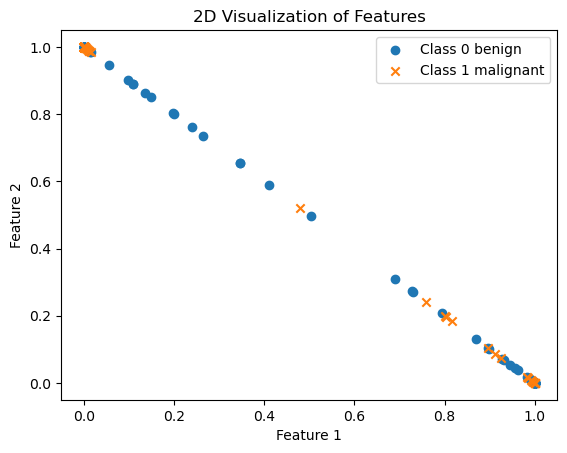

In [113]:
X_train_features = ann_model.predict(X_train_flatten)
X_test_features = ann_model.predict(X_test_flatten)

# The characteristics of the first 200 samples were extracted
X_subset = X_train_features[:200]
# Get the labels for the first 200 samples
y_subset = y_train[:200]

# 根据标签绘制散点图
plt.scatter(X_subset[y_subset == 0, 0], X_subset[y_subset == 0, 1], marker='o', label='Class 0 benign')  # 使用圆圈表示类别0
plt.scatter(X_subset[y_subset == 1, 0], X_subset[y_subset == 1, 1], marker='x', label='Class 1 malignant')  # 使用叉号表示类别1

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('2D Visualization of Features')
plt.show()

In [114]:
print(X_subset[1])

[9.9965465e-01 3.4535889e-04]


In [115]:
print(y_subset[:200])

[0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0.
 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0.
 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0.
 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0.
 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0.
 1. 1. 1. 0. 0. 0. 0. 0.]


## Obtaining the first two hundred samples and transforming them into points distributed on a two-dimensional plot

## Custom KNN Algorithm

In [116]:
class MyKNNClassifier:
    def __init__(self, n_neighbors=3):
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        y_pred = []
        for test_point in X_test:
            # Calculate Euclidean distance
            distances = np.sqrt(np.sum((self.X_train - test_point) ** 2, axis=1))
            # Gets the index of the nearest k neighbors
            nearest_neighbors_indices = np.argsort(distances)[:self.n_neighbors]
            # Get the label of the nearest neighbor
            nearest_labels = self.y_train[nearest_neighbors_indices]        
            # Use a simple voting method to determine prediction labels
            unique_labels, counts = np.unique(nearest_labels, return_counts=True)
            predicted_label = unique_labels[np.argmax(counts)]
            y_pred.append(predicted_label)

        return np.array(y_pred)

# accuracy in computation
correct_predictions = np.sum(y_pred_custom_knn == y_test)
total_samples = len(y_test)
accuracy_custom_knn = correct_predictions / total_samples    

## Transforming into an image to find the most suitable value for the nearest neighbors, K

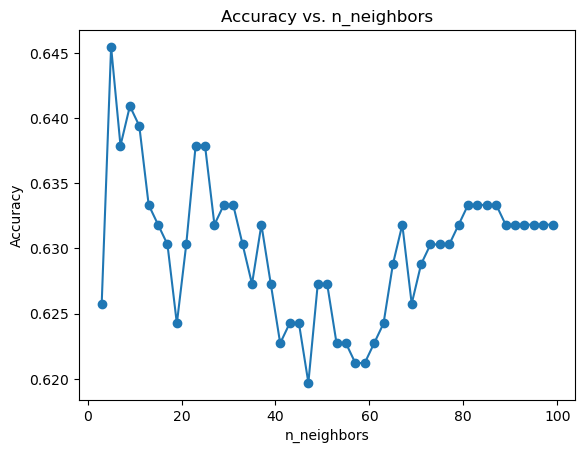

Highest accuracy: 0.6454545454545455，n_neighbors: 5


In [117]:
scaler = StandardScaler()
X_train_features_std = scaler.fit_transform(X_train_features)
X_test_features_std = scaler.transform(X_test_features)

best_accuracy = 0
best_n_neighbors = 0
neighbors_range = range(3, 101, 2)
accuracies = []
for n_neighbors in neighbors_range:
    my_knn_classifier = MyKNNClassifier(n_neighbors=n_neighbors)
    my_knn_classifier.fit(X_train_features_std, y_train)
    y_pred_custom_knn = my_knn_classifier.predict(X_test_features_std)
    accuracy_custom_knn = np.mean(y_pred_custom_knn == y_test)
    accuracies.append(accuracy_custom_knn)
    # Updates the best accuracy and the corresponding n_neighbors value
    if accuracy_custom_knn > best_accuracy:
        best_accuracy = accuracy_custom_knn
        best_n_neighbors = n_neighbors

plt.plot(neighbors_range, accuracies, marker='o')
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. n_neighbors')
plt.show()
print(f"Highest accuracy: {best_accuracy}，n_neighbors: {best_n_neighbors}")

## Structure Accuracy,Precision and Recall function of KNN

In [118]:
my_knn_classifier = MyKNNClassifier(n_neighbors=5)
my_knn_classifier.fit(X_train_features_std, y_train)
y_pred_custom_knn = my_knn_classifier.predict(X_test_features_std)
precision_custom_knn, recall_custom_knn = calculate_precision_recall(y_test, y_pred_custom_knn)
print("Accuracy  :", accuracy_custom_knn)
print("KNN Precision    :", precision_custom_knn)
print("KNN Recall:", recall_custom_knn)

Accuracy  : 0.6318181818181818
KNN Precision    : 0.6057692307692307
KNN Recall: 0.63
